In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker

In [2]:
ensembles = list(range(1,199))

In [3]:
sio2_dict = {ensemble:{} for ensemble in ensembles}
n_impact_dict = {}
for ensemble in ensembles:
    for layer in range(12):
        with open("../data/IMPaCS/sio2_percent_tables/july2025/ensemble_{:d}_{:d}.csv".format(ensemble, layer), "r")as f:
            sio2_dict[ensemble][layer] = pd.read_csv(f).fillna(0)
    with open("../data/IMPaCS/impact_probabilities_export_july2025/ensemble_{:d}.csv".format(ensemble), "r")as f:
        n_impact_dict[ensemble] = pd.read_csv(f).fillna(0)

In [4]:
sio2_dict[ensemble]

{0:      Unnamed: 0         45         50         55         52         53  \
 0             0  79.079442  20.437466   0.483092   0.000000   0.000000   
 1             1  78.227322  20.383790   1.355341   0.033548   0.000000   
 2             2  76.878690  19.940955   1.435856   0.033548   1.710950   
 3             3  74.959742  21.833065   1.435856   0.060386   1.710950   
 4             4  74.778583  11.668009   0.254965  12.647611   0.650832   
 ..          ...        ...        ...        ...        ...        ...   
 495         495   0.764895  10.681696  16.579442  12.030327  17.726785   
 496         496   0.764895  10.681696  16.525765  12.063875  17.746914   
 497         497   0.764895  10.674987  16.519055  12.110843  17.746914   
 498         498   0.764895  10.607890  16.451959  12.084004  17.733494   
 499         499   0.764895  10.594471  16.404992  12.050456  17.820719   
 
            57         54         51        56        58        59        60  \
 0    0.000000 

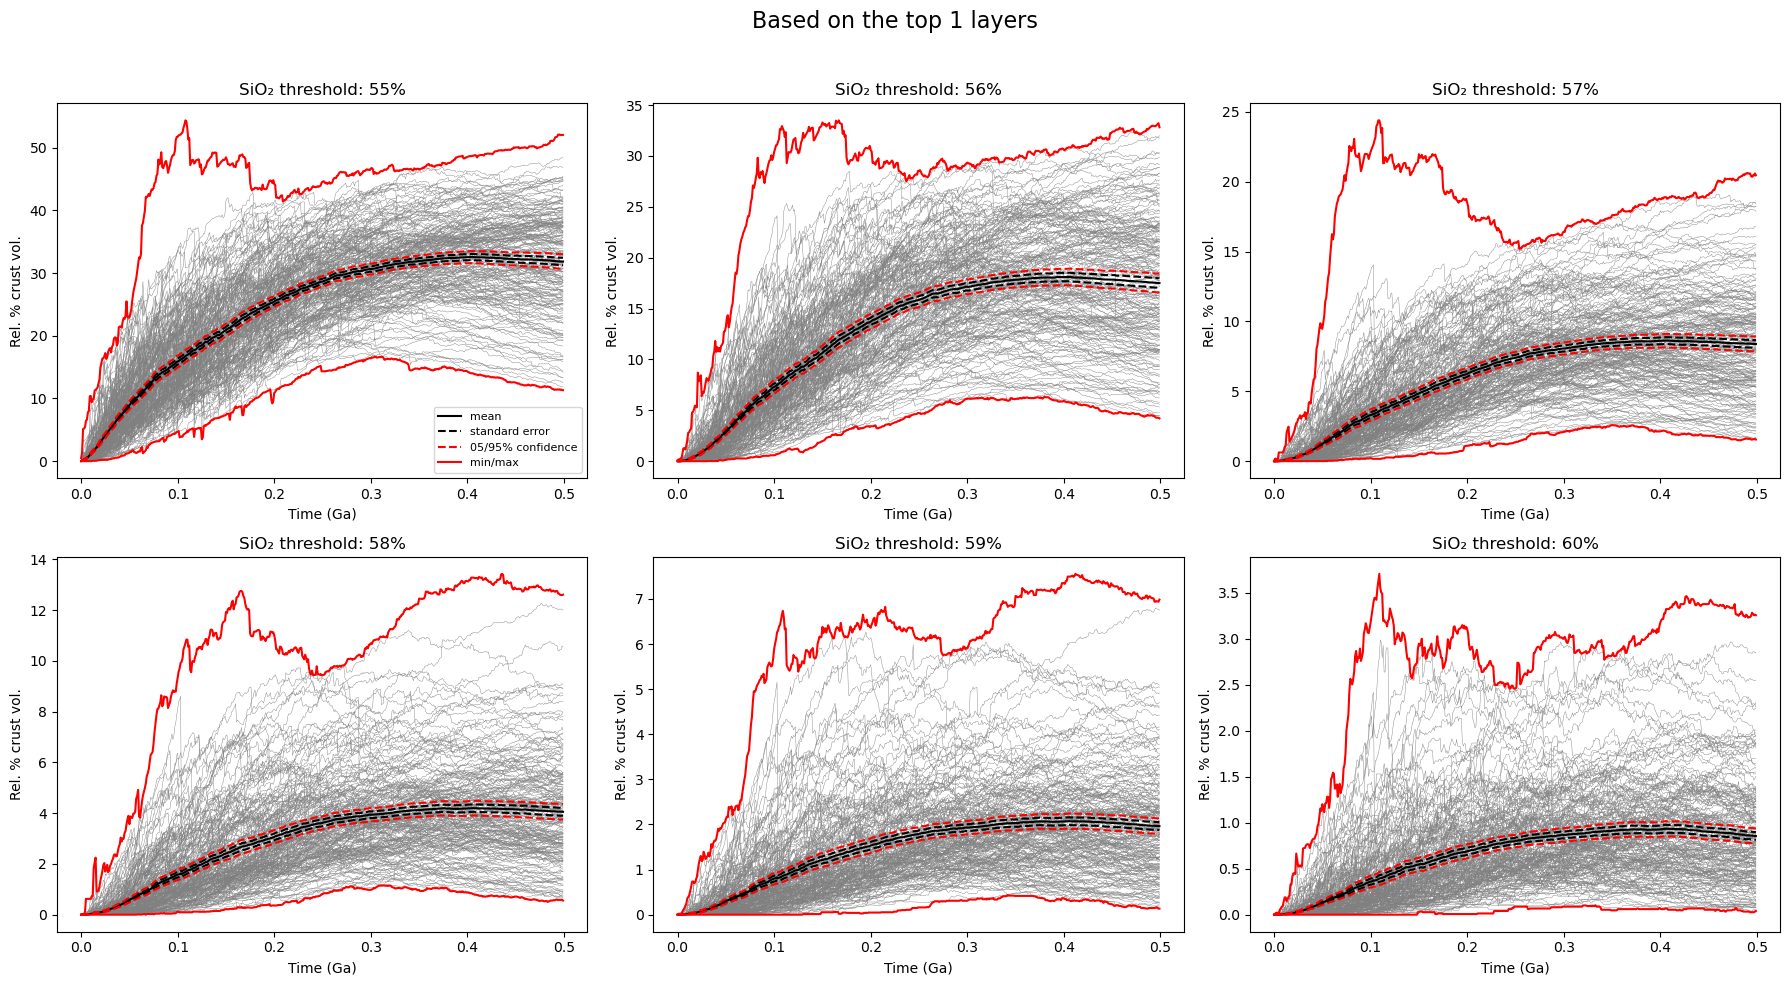

In [5]:

n_layers = 1
CRUST_THRESHOLDS = [55, 56, 57, 58, 59, 60]

# Equal weights for each layer
layer_weights = [1.0 / n_layers] * n_layers

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, CRUST_THRESHOLD in enumerate(CRUST_THRESHOLDS):
    crust_dict = {}

    for ensemble in ensembles:
        # Plotting (still just the top layer, for visualization consistency)
        percent_bins_top = [
            str(p) for p in range(CRUST_THRESHOLD, 101)
            if str(p) in sio2_dict[ensemble][0].columns
        ]
        df_top = sio2_dict[ensemble][0][percent_bins_top].sum(axis=1)
        axes[i].plot(df_top.index.values / 1000, df_top.values, lw=0.3, c='grey',
                     label='ensemble member' if ensemble == 0 else None)

        # Stats: properly weighted sum across layers
        total = None
        for layer in range(n_layers):
            percent_bins = [
                str(p) for p in range(CRUST_THRESHOLD, 101)
                if str(p) in sio2_dict[ensemble][layer].columns
            ]
            df = sio2_dict[ensemble][layer][percent_bins].sum(axis=1)
            weighted_df = layer_weights[layer] * df
            total = weighted_df if total is None else total + weighted_df

        crust_dict[ensemble] = total

    # Build DataFrame from ensemble member totals
    crust_df = pd.DataFrame(crust_dict)

    # Compute statistics
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev'] / np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c05'] = crust_df['mean'] - 1.96 * standard_error
    crust_df['c95'] = crust_df['mean'] + 1.96 * standard_error

    xvals = crust_df.index.values / 1000
    ax = axes[i]
    ax.plot(xvals, crust_df['mean'], c='k', label='mean')
    ax.plot(xvals, crust_df['e05'], '--', c='k', label='standard error')
    ax.plot(xvals, crust_df['e95'], '--', c='k')
    ax.plot(xvals, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
    ax.plot(xvals, crust_df['c95'], '--', c='r')
    ax.plot(xvals, crust_df['min'].clip(lower=0), c='r', label='min/max')
    ax.plot(xvals, crust_df['max'], c='r')

    ax.set_title(f"SiO₂ threshold: {CRUST_THRESHOLD}%")
    ax.set_xlabel("Time (Ga)")
    ax.set_ylabel("Rel. % crust vol.")
    if i == 0:
        ax.legend(fontsize=8)

# Add overall title
fig.suptitle(f"Based on the top {n_layers} layers", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.show()

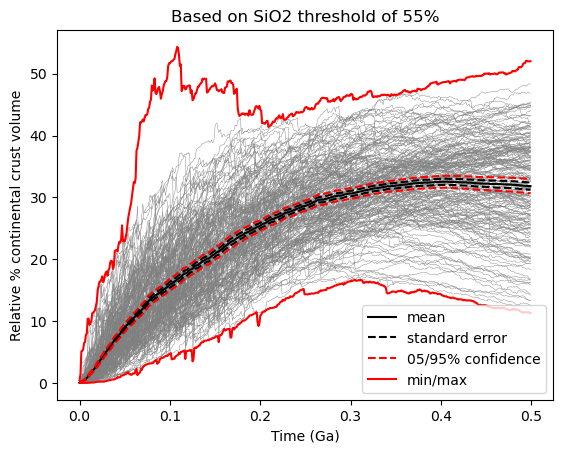

In [6]:
CRUST_THRESHOLD = 55

n_layers=1
crust_dict = {}
for ensemble in ensembles:
    for layer in range(n_layers):
        
        percent_bins=[]
        for p in range(CRUST_THRESHOLD,101):
            if str(p) in list(sio2_dict[ensemble][layer].columns.values):
                percent_bins.append(str(p))
                
        df = sio2_dict[ensemble][layer].loc[:,percent_bins].sum(axis=1)

        if layer == 0:
            crust_dict[ensemble] = df.values
        else:
            crust_dict[ensemble] += df.values
            
    if ensemble == 0:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey', label='ensemble member')
    else:
        plt.plot(df.index.values/1000, df.values, lw=0.3, c='grey')
            
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    
    crust_mean = crust_df.mean(axis=1)

crust_df['mean'] = crust_df.mean(axis=1)
crust_df['min'] = crust_df.min(axis=1)
crust_df['max'] = crust_df.max(axis=1)
crust_df['stdev'] = crust_df.std(axis=1)
standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
crust_df['e05'] = crust_df['mean'] - standard_error
crust_df['e95'] = crust_df['mean'] + standard_error
crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
crust_df['c05'] = crust_df['mean'] - standard_error * 1.96

plt.plot(df.index.values/1000, crust_df['mean'], c='k', label='mean')
plt.plot(df.index.values/1000, crust_df['e05'], '--', c='k', label='standard error')
plt.plot(df.index.values/1000, crust_df['e95'], '--', c='k')
plt.plot(df.index.values/1000, crust_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(df.index.values/1000, crust_df['c95'], '--', c='r')
plt.plot(df.index.values/1000, crust_df['min'].clip(lower=0), c='r', label='min/max')
plt.plot(df.index.values/1000, crust_df['max'], c='r')
plt.title(f"Based on SiO2 threshold of {CRUST_THRESHOLD/100:.0%}")
plt.xlabel("Time (Ga)")
plt.ylabel("Relative % continental crust volume")
#plt.ylim([0,20])
plt.legend()
# plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/relative_percent_crust_over_time_bound.png', dpi=600)
plt.show()
plt.close()

In [7]:
final_values = {summary_characteristic:[] for summary_characteristic in ['mean', 'min', 'max',
                                                                         'standard_error', 'CI95']}
for i in range(3,len(ensembles)+1):
    crust_dict = {}
    for ensemble in ensembles[:i]:
        percent_bins=[]
        for p in range(CRUST_THRESHOLD,100):
            if str(p) in list(sio2_dict[ensemble][0].columns.values):
                percent_bins.append(str(p))
        df = 100* sio2_dict[ensemble][0].loc[:,percent_bins].sum(axis=1) / 40
        crust_dict[ensemble] = df.values
    crust_df = pd.DataFrame(crust_dict, index=df.index.values)
    crust_mean = crust_df.mean(axis=1)
    crust_df['mean'] = crust_df.mean(axis=1)
    crust_df['min'] = crust_df.min(axis=1)
    crust_df['max'] = crust_df.max(axis=1)
    crust_df['stdev'] = crust_df.std(axis=1)
    standard_error = crust_df['stdev']/np.sqrt(len(ensembles))
    crust_df['e05'] = crust_df['mean'] - standard_error
    crust_df['e95'] = crust_df['mean'] + standard_error
    crust_df['c95'] = crust_df['mean'] + standard_error * 1.96
    crust_df['c05'] = crust_df['mean'] - standard_error * 1.96
    final_values['mean'].append(crust_df['mean'][499])
    final_values['min'].append(crust_df['min'][499])
    final_values['max'].append(crust_df['max'][499])
    final_values['standard_error'].append(standard_error[499])
    final_values['CI95'].append(standard_error[499] * 1.96)

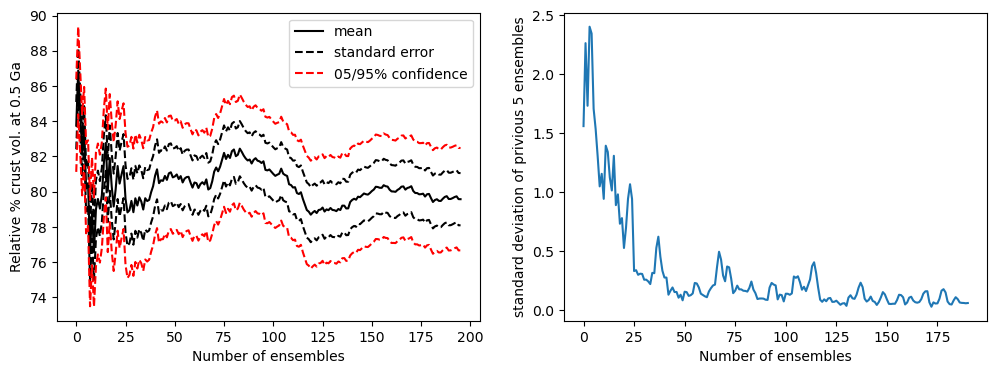

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)    
ax.plot(final_values['mean'], c='k', label='mean')
ax.plot(np.array(final_values['mean'])+np.array(final_values['standard_error']), 
         '--', c='k', label='standard error')
ax.plot(np.array(final_values['mean'])-np.array(final_values['standard_error']),'--', c='k', )
ax.plot(np.array(final_values['mean'])+np.array(final_values['CI95']), 
         '--', c='r', label='05/95% confidence')
ax.plot(np.array(final_values['mean'])-np.array(final_values['CI95']),'--', c='r', )
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("Relative % crust vol. at 0.5 Ga")
plt.legend()

std_last_5_ens = []
for i in range(5,len(final_values['mean'])):
    std_last_5_ens.append(np.std(final_values['mean'][i-5:i]))
ax = fig.add_subplot(1, 2, 2)
ax.plot(std_last_5_ens)
ax.set_xlabel("Number of ensembles")
ax.set_ylabel("standard deviation of privious 5 ensembles")
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/ensemble_convergence_bound.png', dpi=600)
plt.show()
plt.close()

In [9]:
total_impact_dict = {}
total_impact_dict['low'] = n_impact_dict[ensemble].low
total_impact_dict['high'] = n_impact_dict[ensemble].high
for ensemble in ensembles:
    total_impact_dict[ensemble] = n_impact_dict[ensemble].total

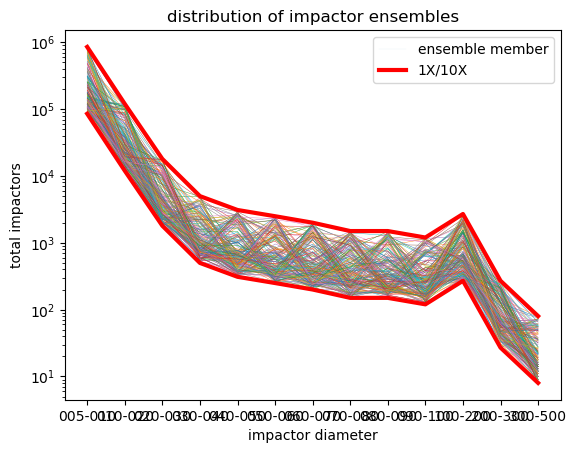

In [10]:
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(total_impact_dict[ensemble], lw=0.03, label="ensemble member")
    else:
        plt.plot(total_impact_dict[ensemble], lw=0.3)
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['low'], c='r', lw=3, label='1X/10X')
plt.plot(n_impact_dict[1]['Unnamed: 0'], total_impact_dict['high'], c='r', lw=3)
plt.ylabel('total impactors')
plt.yscale('log')
plt.xlabel("impactor diameter")
plt.title("distribution of impactor ensembles")
plt.legend()
# plt.savefig('./figs/paper_figs/total_impacts_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/total_impacts_bound.png', dpi=600)
plt.show()
plt.close()

In [11]:
max_sio2_list={layer:{} for layer in range(12)}
for layer in range(11):
    for ensemble in ensembles:
        max_sio2_list[layer][ensemble]=[]
        for irow in sio2_dict[ensemble][layer].index.values:
            max_sio2_percent=0
            for icol in sio2_dict[ensemble][layer].columns.values[1:]:
                if sio2_dict[ensemble][layer].loc[irow,icol] > 0:
                    if int(icol) > max_sio2_percent:
                        max_sio2_percent = int(icol)
            max_sio2_list[layer][ensemble].append(max_sio2_percent)

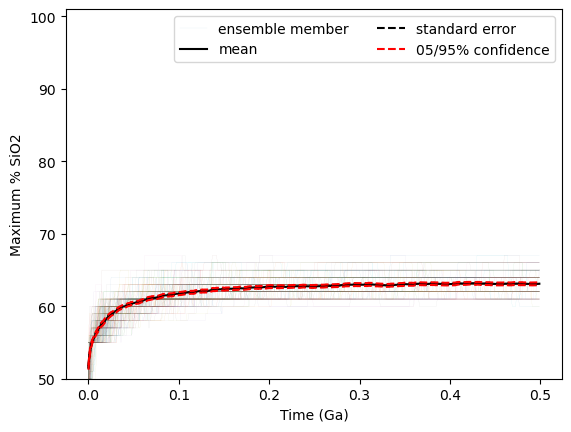

In [12]:
max_sio2_df          = pd.DataFrame(max_sio2_list[0])
max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
max_sio2_df['min']   = max_sio2_df.min(axis=1)
max_sio2_df['max']   = max_sio2_df.max(axis=1)
max_sio2_df['stdev'] = max_sio2_df.std(axis=1)
standard_error       = max_sio2_df['stdev']/np.sqrt(len(ensembles))
max_sio2_df['e05']   = max_sio2_df['mean'] - standard_error
max_sio2_df['e95']   = max_sio2_df['mean'] + standard_error
max_sio2_df['c95']   = max_sio2_df['mean'] + standard_error * 1.96
max_sio2_df['c05']   = max_sio2_df['mean'] - standard_error * 1.96
for ensemble in ensembles:
    if ensemble == 1:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], 
                 lw=0.03, label="ensemble member")        
    else:
        plt.plot(max_sio2_df.index.values/1000, max_sio2_list[0][ensemble], lw=0.03)

plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], c='k', label='mean')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e05'], '--', c='k', label='standard error')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['e95'], '--', c='k')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c05'].clip(lower=0), '--', c='r', label='05/95% confidence')
plt.plot(max_sio2_df.index.values/1000, max_sio2_df['c95'], '--', c='r')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['min'].clip(lower=0), c='r', label='min/max')
# plt.plot(max_sio2_df.index.values/1000, max_sio2_df['max'], c='r')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,101])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

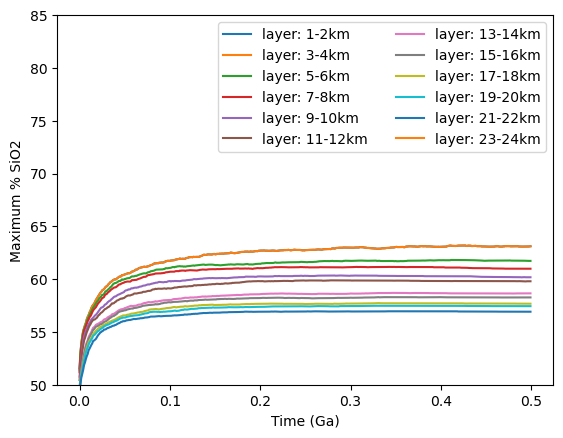

In [13]:
llyr = {0:"1-2km",1:"3-4km",2:"5-6km",3:"7-8km",4:"9-10km",5:"11-12km",
        6:"13-14km",7:"15-16km",8:"17-18km",9:"19-20km",10:"21-22km",11:"23-24km"}
for layer in range(12):
    max_sio2_df          = pd.DataFrame(max_sio2_list[layer])
    max_sio2_df['mean']  = max_sio2_df.mean(axis=1)
    plt.plot(max_sio2_df.index.values/1000, max_sio2_df['mean'], label=f'layer: {llyr[layer]}')
plt.xlabel("Time (Ga)")
plt.ylabel("Maximum % SiO2")
plt.ylim([50,85])
plt.legend(ncol=2)
# plt.savefig('./figs/paper_figs/max_sio2_bound.pdf', dpi=600)
# plt.savefig('./figs/paper_figs/max_sio2_bound.png', dpi=600)
plt.show()
plt.close()

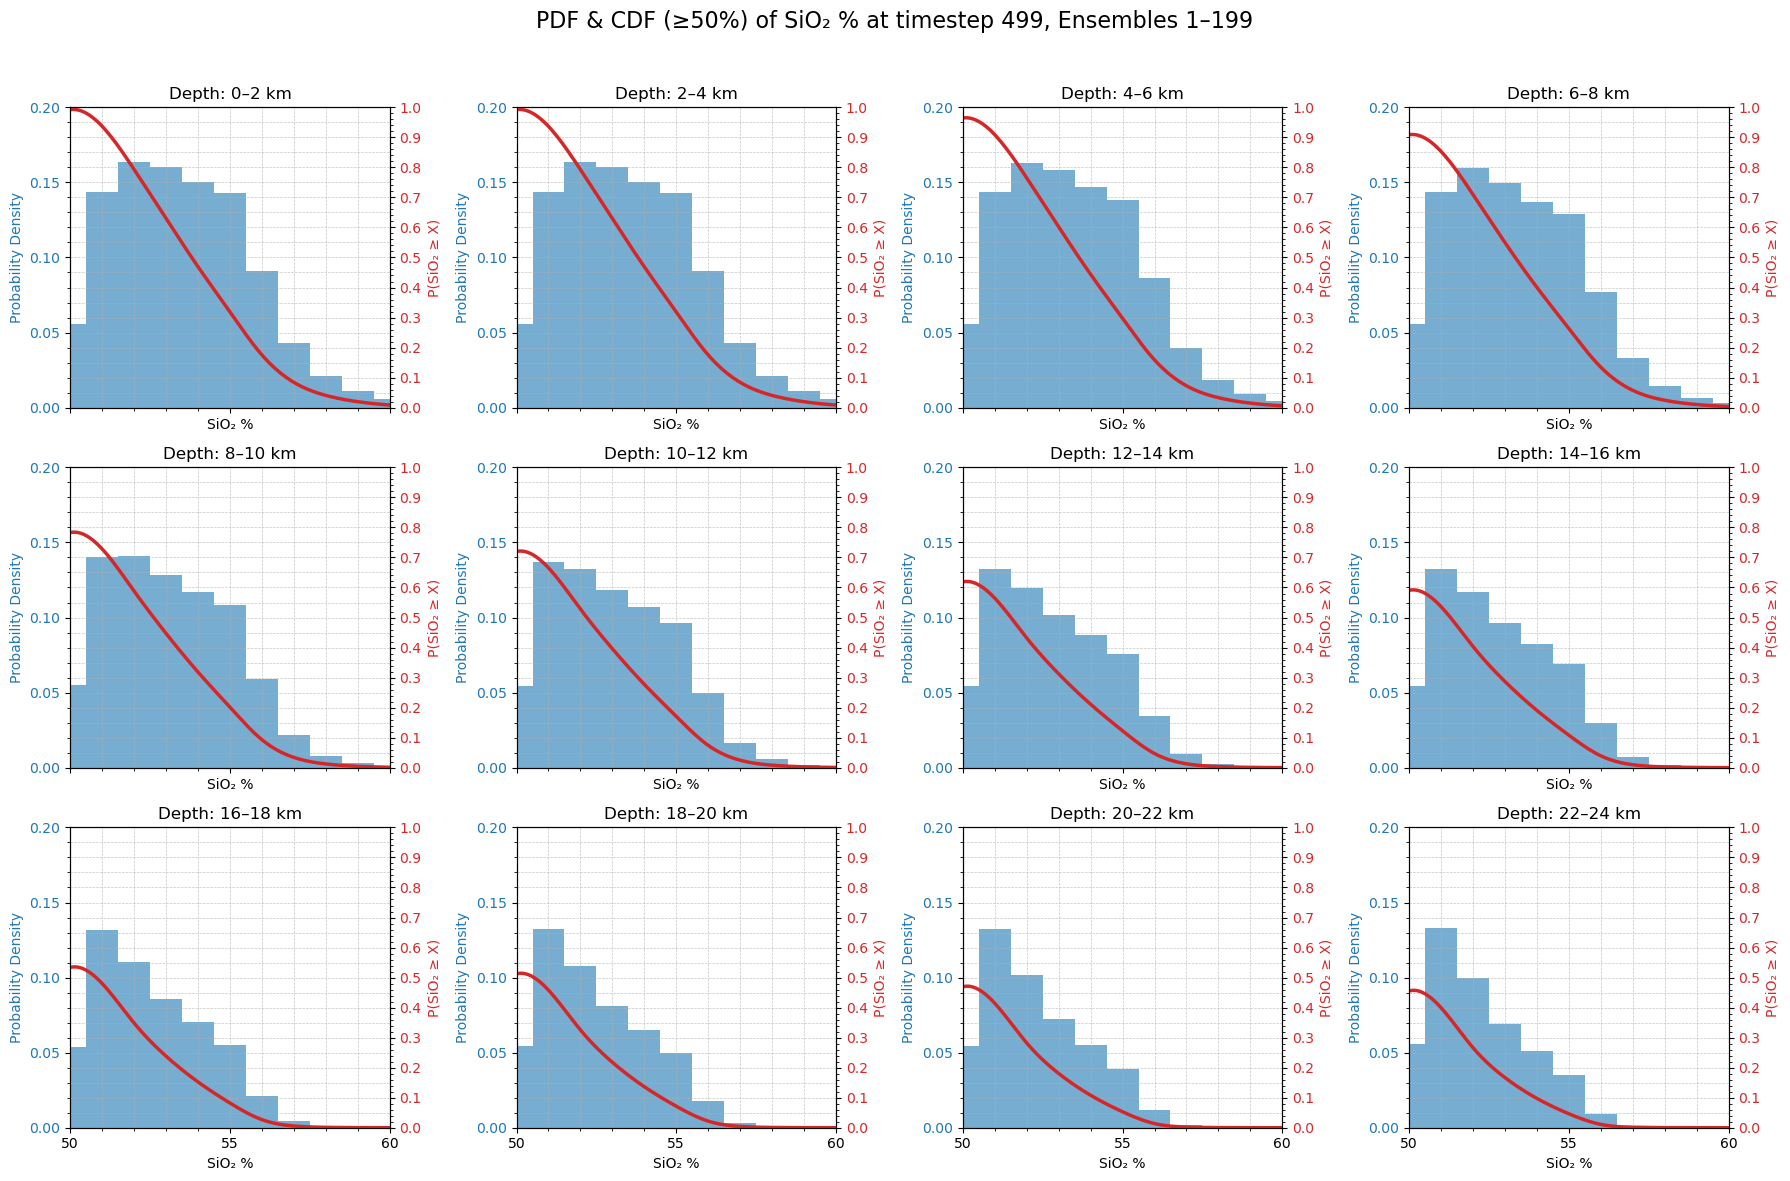

In [20]:
DATA_DIR = "../data/IMPaCS/sio2_percent_tables/july2025"
ENSEMBLES = range(1, 200)
LAYERS = range(0, 12)
FINAL_TIMESTEP = 499

def load_pdf_for_layer(layer):
    all_bins = set()
    pdfs = []
    for e in ENSEMBLES:
        path = os.path.join(DATA_DIR, f"ensemble_{e}_{layer}.csv")
        if not os.path.exists(path):
            continue
        df = pd.read_csv(path, index_col=0)
        if FINAL_TIMESTEP not in df.index:
            continue
        row = df.loc[FINAL_TIMESTEP].dropna()
        try:
            bins = np.array([int(c) for c in row.index])
            values = row.values.astype(float)
        except ValueError:
            continue
        pdf = values / values.sum() if values.sum() > 0 else values
        pdfs.append((bins, pdf))
        all_bins.update(bins)

    if not pdfs:
        return np.array([]), np.array([])

    sorted_bins = np.array(sorted(all_bins))
    pdf_matrix = np.zeros((len(pdfs), len(sorted_bins)))
    for i, (bins, pdf) in enumerate(pdfs):
        idx_map = {b: j for j, b in enumerate(sorted_bins)}
        for b, p in zip(bins, pdf):
            pdf_matrix[i, idx_map[b]] = p
    mean_pdf = pdf_matrix.mean(axis=0)
    return sorted_bins, mean_pdf

def depth_label(layer, dz_km=2):
    start = layer * dz_km
    end = start + dz_km
    return f"{start}–{end} km"

def plot_pdf_cdf_combined():
    fig, axes = plt.subplots(3, 4, figsize=(18, 12), sharex=True, sharey=False)
    axes = axes.flatten()

    for idx, layer in enumerate(LAYERS):
        bins, mean_pdf = load_pdf_for_layer(layer)
        if bins.size == 0:
            continue

        # CDF for ≥50% only
        mask_50 = bins >= 50
        pdf_for_cdf = np.where(mask_50, mean_pdf, 0.0)
        cdf_rev = np.cumsum(pdf_for_cdf[::-1])[::-1]

        # Smooth CDF on the ≥50% domain
        bins_cdf = bins[mask_50]
        cdf_vals = cdf_rev[mask_50]
        if len(bins_cdf) > 3:
            spline = make_interp_spline(bins_cdf, cdf_vals, k=3)
            bins_smooth = np.linspace(bins_cdf.min(), bins_cdf.max(), 200)
            cdf_smooth = spline(bins_smooth)
        else:
            bins_smooth, cdf_smooth = bins_cdf, cdf_vals

        ax = axes[idx]
        ax2 = ax.twinx()

        # PDF (full range)
        ax.bar(bins, mean_pdf, width=1.0, align='center', alpha=0.6, color='tab:blue', label="PDF")
        ax.set_ylabel("Probability Density", color='tab:blue')
        ax.tick_params(axis='y', labelcolor='tab:blue')

        # CDF (≥50%), thicker & smooth
        ax2.plot(bins_smooth, cdf_smooth, color='tab:red', linewidth=2.5, label="CDF (≥50%)")
        ax2.set_ylabel("P(SiO₂ ≥ X)", color='tab:red')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Grid & ticks (your settings)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        ax2.grid(False)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
        ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

        # Your y-limit for PDF
        ax.set_ylim([0, 0.2])
        ax2.set_ylim([0, 1])
        # Apply x-limits per-axes so it propagates with sharex
        ax.set_xlim(50, 60)

        # Title as depth range
        ax.set_title(f"Depth: {depth_label(layer)}")

        ax.set_xlabel("SiO₂ %")

    fig.suptitle(f"PDF & CDF (≥50%) of SiO₂ % at timestep {FINAL_TIMESTEP}, Ensembles 1–199", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run
plot_pdf_cdf_combined()